# Diffusione Termica
**Mattia Sotgia<sup>1</sup>, Francesco Polleri <sup>1</sup>** <br>
_<sup>1</sup>Dipartimento di Fisica, Università degli studi di Genova_


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from utils import Analysis, AnalysisData
from utils import Data

from uncertainties import ufloat

# import ROOT
from iminuit import Minuit
from iminuit.cost import LeastSquares
import mplhep as hep

from scipy import fft
import style

plt.style.use(['std-colors', style.STYLE])

# Analisi dati
Abbiamo acquisito 1200 punti (con frequenza di 10Hz) divisi in 4 dataset, come
 - 2 dataset (`20230321_1_1s` e `20230321_2_1s`) con impulso iniziale di ~1 s
 - 1 dataset con $\Delta_\text{pulse}$ = 0.5 e 1 dataset con 1.5 s

In [2]:
D1 = Data(np.loadtxt('data/20230321_1_1s.lvm', skiprows=23, unpack=True), 1, 1)
D2 = Data(np.loadtxt('data/20230321_2_1s.lvm', skiprows=23, unpack=True), 1, 2)
D3 = Data(np.loadtxt('data/20230321_3_1s.lvm', skiprows=23, unpack=True), 1, 3)
D4 = Data(np.loadtxt('data/20230321_4_0.5s.lvm', skiprows=23, unpack=True), 0.5, 4)
D5 = Data(np.loadtxt('data/20230321_5_1.5s.lvm', skiprows=23, unpack=True), 1.5, 5)

datasets = [D1, D2, D3, D4, D5]

Possiamo così rapidamente analizzare i valori ottenuti (per esempio osservo subito che la temperatura del PT100 risulta invariante rispetto al tempo). Mostriamo ora i dati raccolti, in cinque dataset ($D_{1\dots5}$).

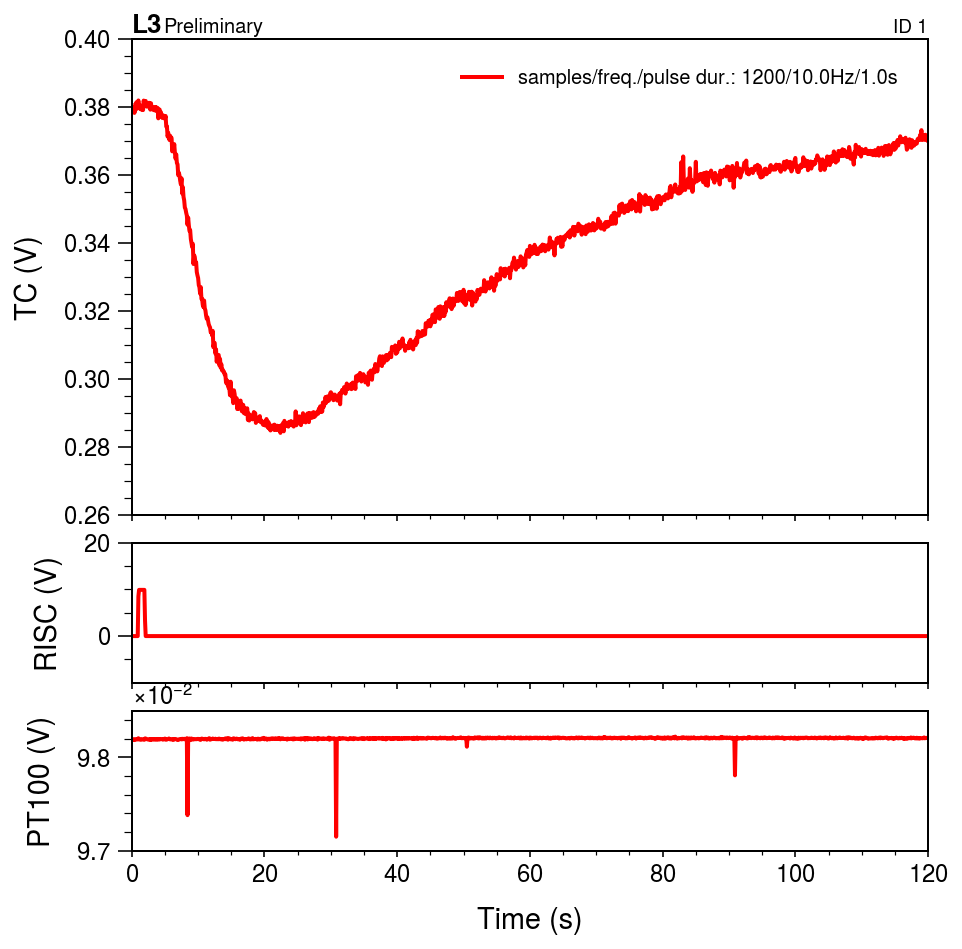

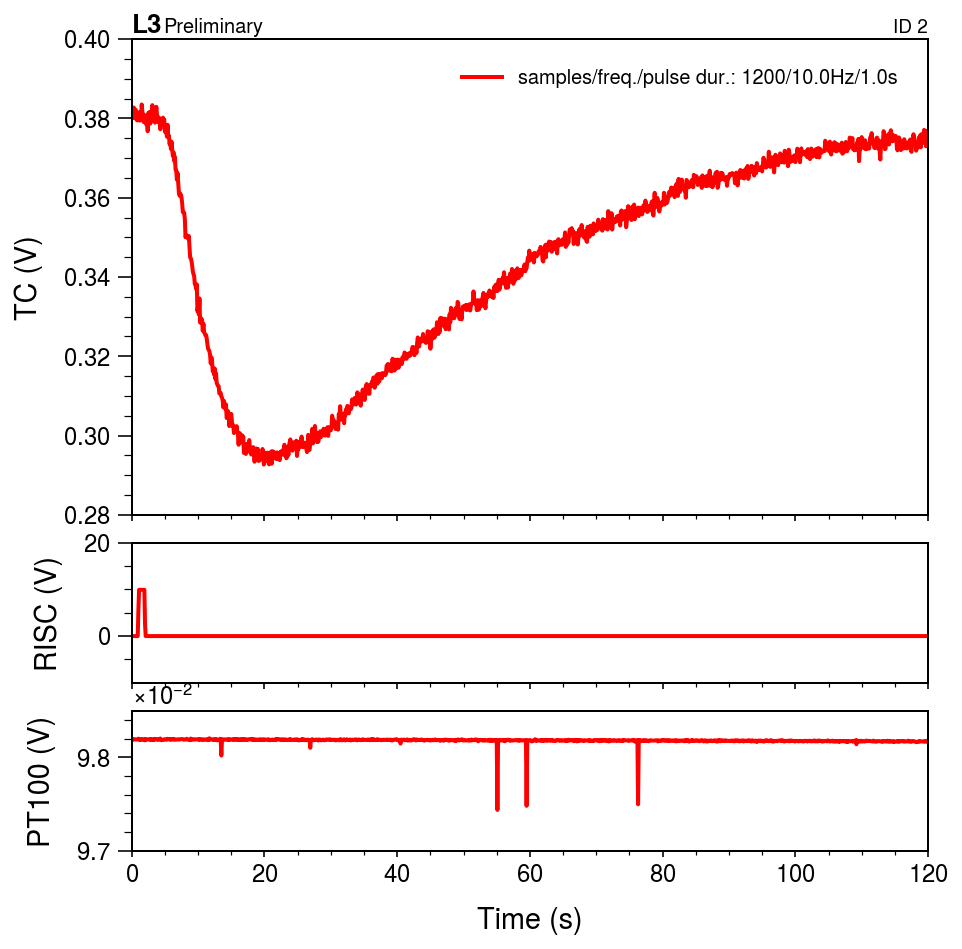

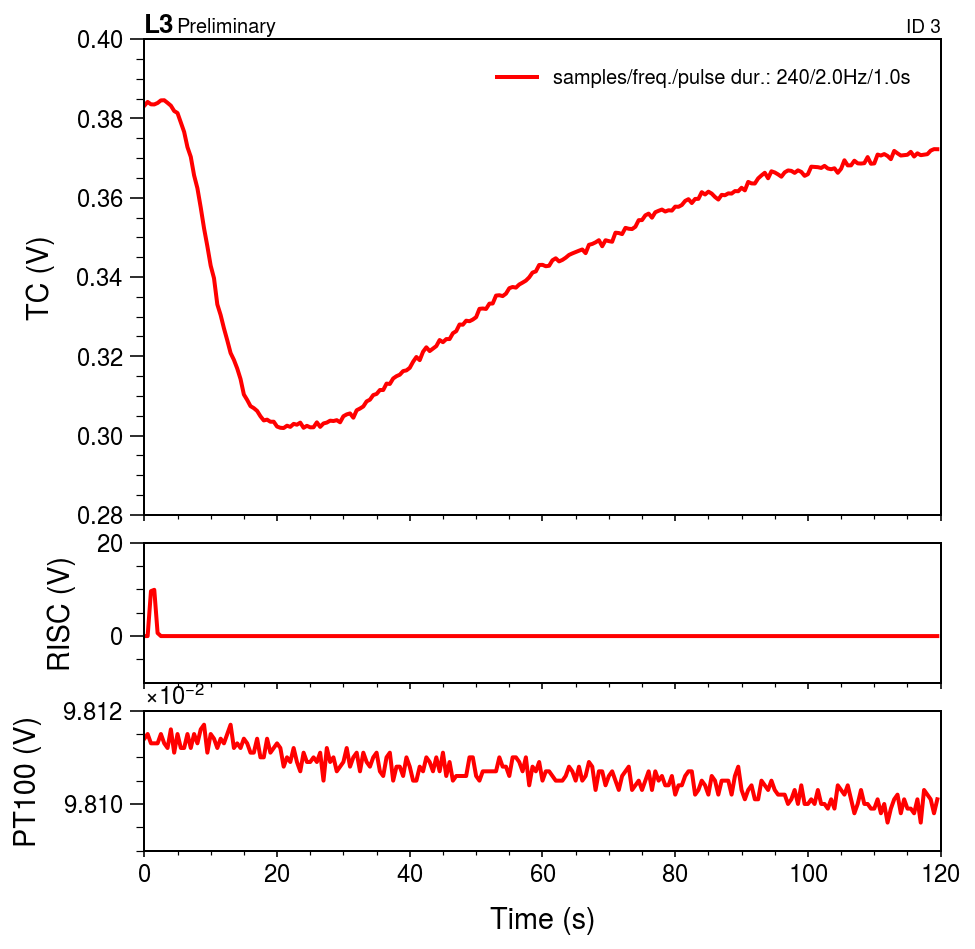

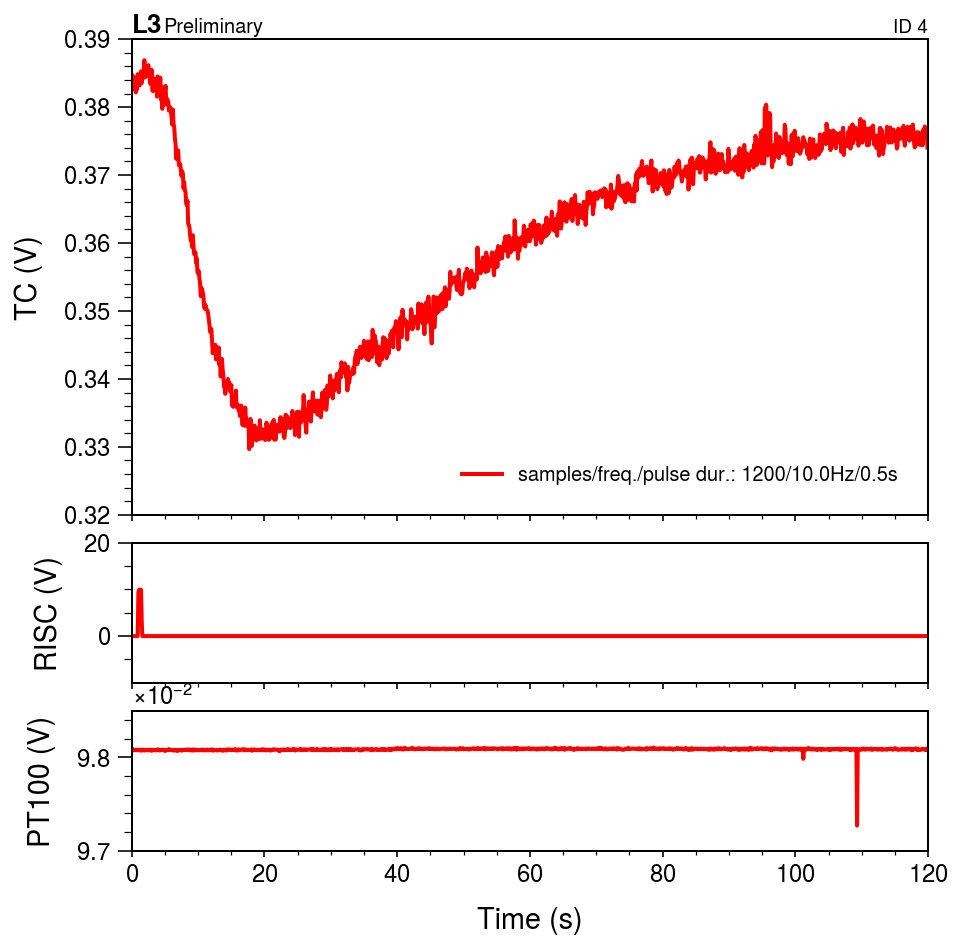

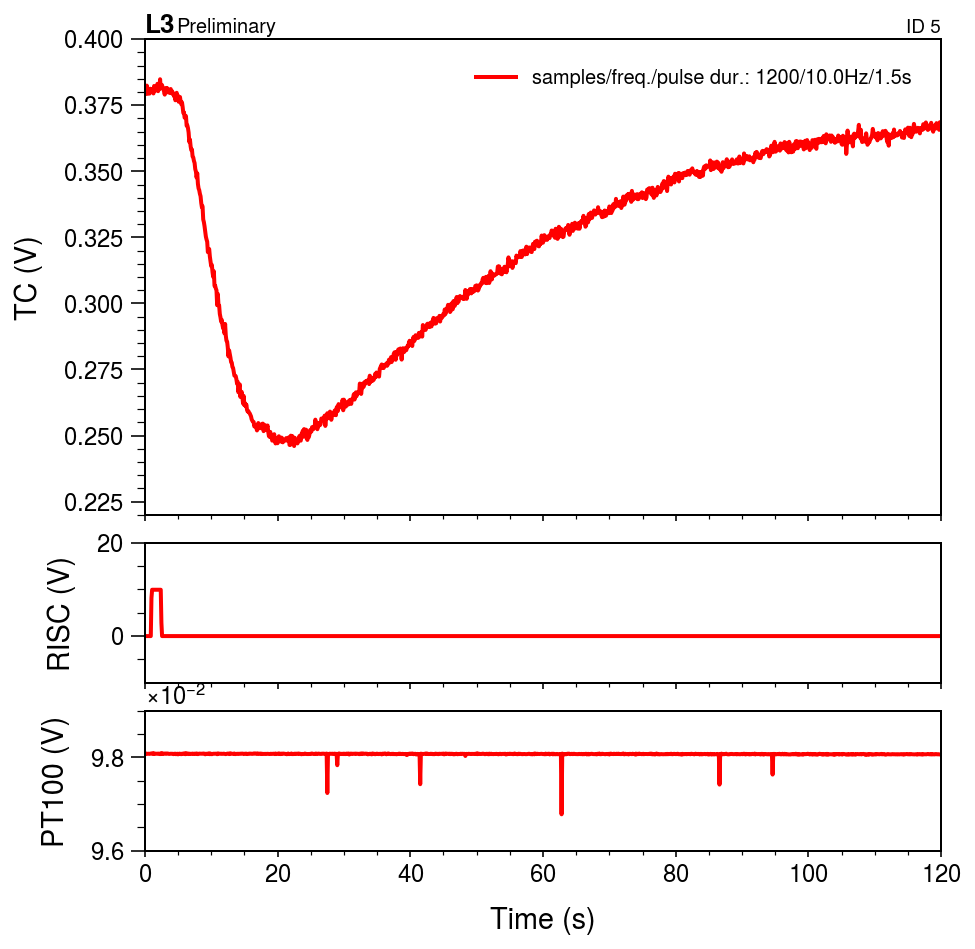

In [3]:
for D in datasets:
    D.prelim_plot()

Data l'equazione per una sbarretta semi-infinita (correggo poi dopo con una restrizione del dominio), $$\frac{\partial T}{\partial t} = k \nabla T,$$ possiamo ottenere soluzione del tipo $$T(x,t) = \frac{C}{\sqrt{Dt}} \exp(-\frac{x^2}{4Dt}) + T_0. \tag{1}, \label{eq:1}$$

## Linearizzazione

Posso osservare che graficando idealmente $$\log{\sqrt{t}T_\text{TC}} = \log\left(\frac{C}{\sqrt{D}} \exp(-\frac{x^2}{4Dt})\right)\tag{2}$$ contro $1/t$, allora diventa $f(1/t) = -\frac{x_0^2}{4Dt}$, che risulta essere più comoda da trattare

Per esempio, la regione in cui la linearizzazione può essere valida è per il $D_1$:

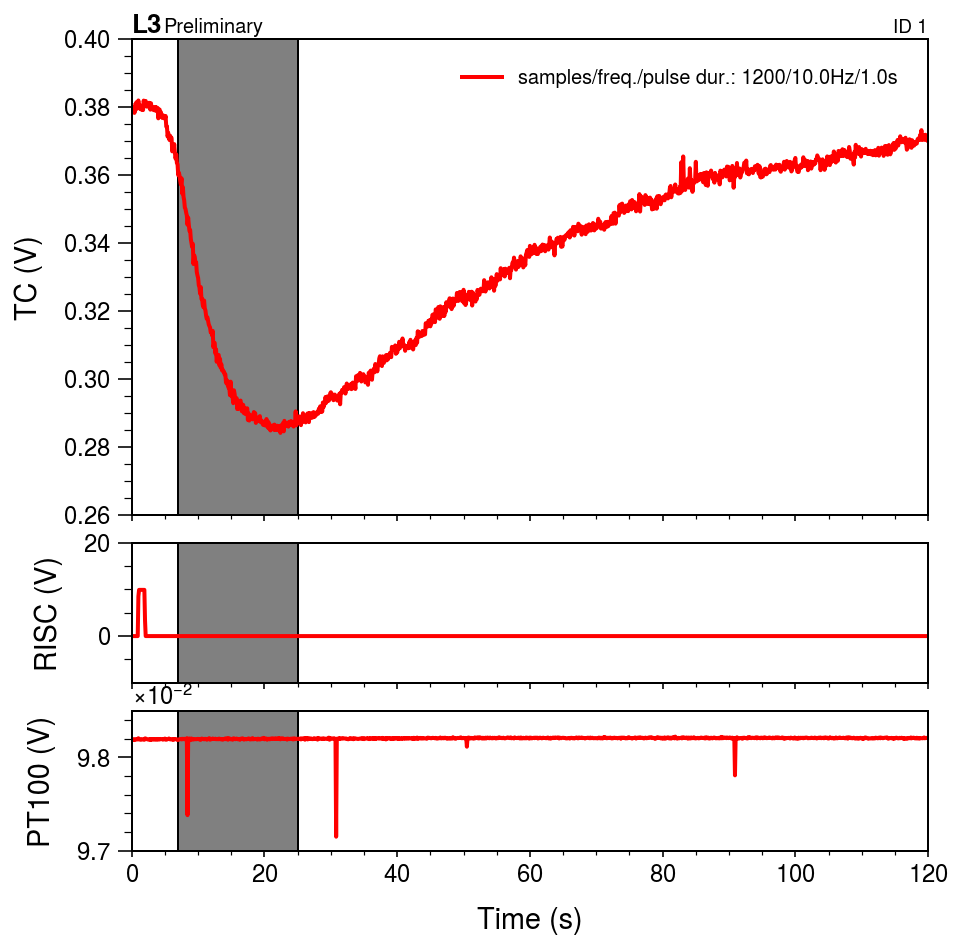

In [4]:
low, up = 7, 25
D1.prelim_plot(low,up)

Quindi otteniamo che i dati linearizzati si dispongono come 

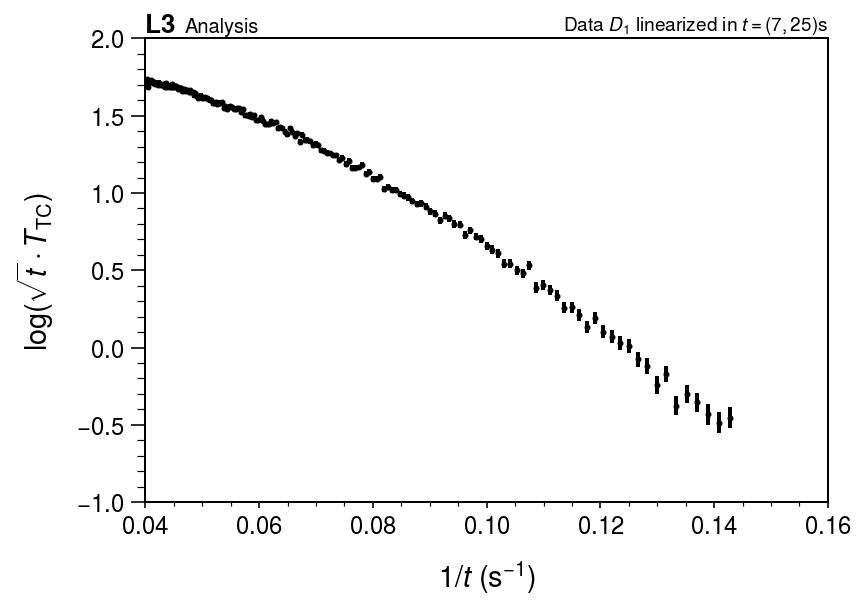

In [5]:
_ = Analysis(D1).filter(low, up).plot_linearized()
hep.label.exp_text('L3 ', 'Analysis')
_ = hep.label.lumitext(f'Data $D_1$ linearized in $t = ({low}, {up})$s')

Con un fit lineare possiamo ottenere i seguenti valori di $D$ per $D_{1\dots5}$

┌─────────────────────────────────────────────────────────────────────────    
│ D = 6.16(5)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D1)    
│ (p-value: 0.0, χ2/df = (671.1341958436437, 178.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 6.22(7)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D2)    
│ (p-value: 0.0, χ2/df = (686.9624284589394, 178.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 5.95(10)e-06 m^2/s 	for samples/freq./pulse dur.: 240/2.0Hz/1.0s (D3)    
│ (p-value: 0.0, χ2/df = (267.1073074133845, 34.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 6.14(9)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/0.5s (D4)    
│ (p-value: 1.0658152138631749e-10, χ2/df = (325.182819006462, 178.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 5.96(5)e-06 m^2/s 	for samples/freq./pulse 

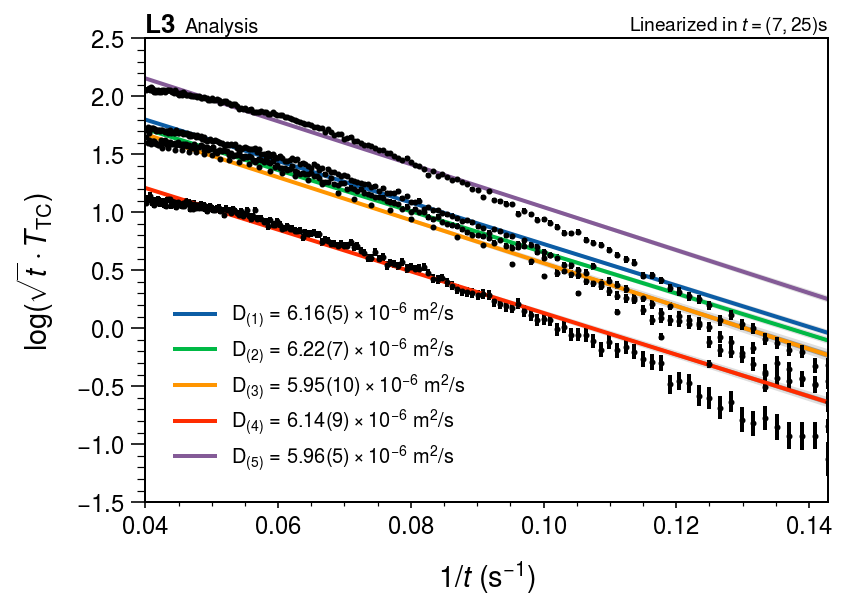

In [6]:
for i, D in enumerate(datasets):
    value, error, M = Analysis(D).filter(low, up).linearized_model_fit(-30, 2)

plt.xlim(1/up, 1/low) # adjust th xlim (broken?)
hep.label.exp_text('L3 ', 'Analysis')
hep.label.lumitext(f'Linearized in $t = ({low}, {up})$s')
plt.legend()
plt.savefig('lplot_1-5.pdf', bbox_inches='tight')

### Osservazioni

Per linearizzare abbiamo considerato che nell'equazione precedente la termocoppia portasse effettivamente ad una differenza rispetto allo zero, per cui ci potevamo aspettare che inizialmente (quando il sistema è fermo e non stimolato) la temperatura fosse effettivamente nulla (ci aspettavamo una risposta come data dal grafico sotto in basso). Dalle misure osserviamo che invece la temperatura di risposta della termocoppia è invece data con un offset iniziale, non trascurabile. 

Questo porta ad una conseguanza alla relazione precedente, in quanto la risposta è data come in (1), con un termine $T_0$, che non possiamo ignorare, e che nella relazione (2) porterebbe ad avere una correzione dentro il logaritmo come $\log(\sqrt{t}T(1/t) + \sqrt{t}T_0)$, che non è allora più una relazione lineare. Per valori di $T_0\ll1$ avremmo una buona stima con una approssimazione lineare (al primo ordine), ma in questi casi l'offset non risulta trascurabile, soprattutto se confrontato con il valore di variazione indotta dall'impulso. 

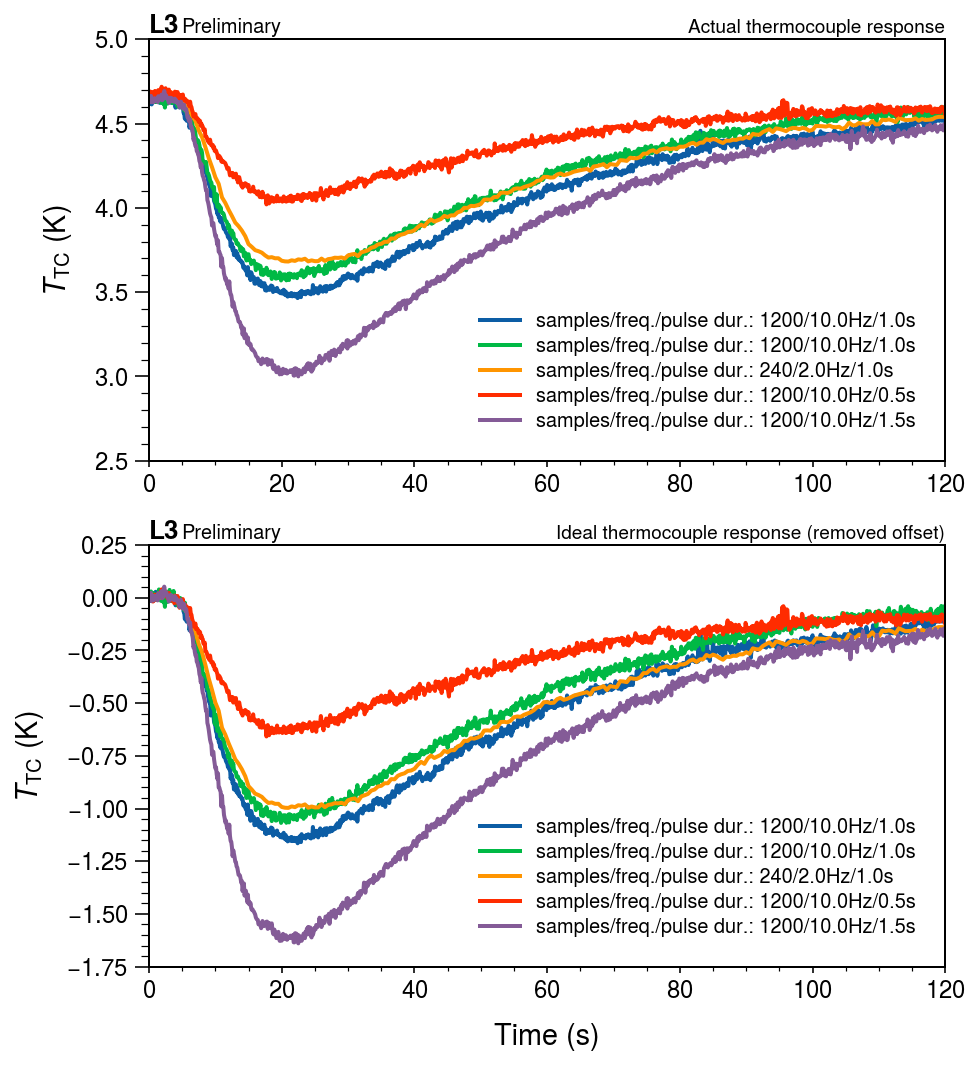

In [7]:
def get_original(data: Analysis):
    return - data.data.T_TC + data.offset

plt.figure(figsize=(7, 8))

plot = plt.subplot(2,1,1)

for D in datasets:
    plt.plot(D.time, get_original(Analysis(D)), label=D.name)
# plt.xlabel('Time (s)')
plt.ylabel('$T_\mathrm{TC}$ (K)')
hep.label.exp_text('L3','Preliminary')
hep.label.lumitext('Actual thermocouple response')
_ = plt.legend()

plt.subplot(2,1,2, sharex=plot)

for i, D in enumerate(datasets):
    plt.plot(D.time[1:], - Analysis(D).data.T_TC[1:], label=D.name)
plt.xlabel('Time (s)')
plt.ylabel('$T_\mathrm{TC}$ (K)')
hep.label.exp_text('L3','Preliminary')
hep.label.lumitext('Ideal thermocouple response (removed offset)')
_ = plt.legend()

Per ottenere una linearizzazione valida abbiamo allora valutato per i primi istanti di presa dati, dove quindi (come possiamo vedere nel grafico sotto, dove è fatto uno zoom sui primi 5s della presa dati) effettuando una media possiamo ottenere una valore dell'offset, che possiamo quindi rimuovere. 

Inoltre l'amplificatore invertente ha un guadagno negativo, per cui i dati andranno presi con un sengo invertito. 

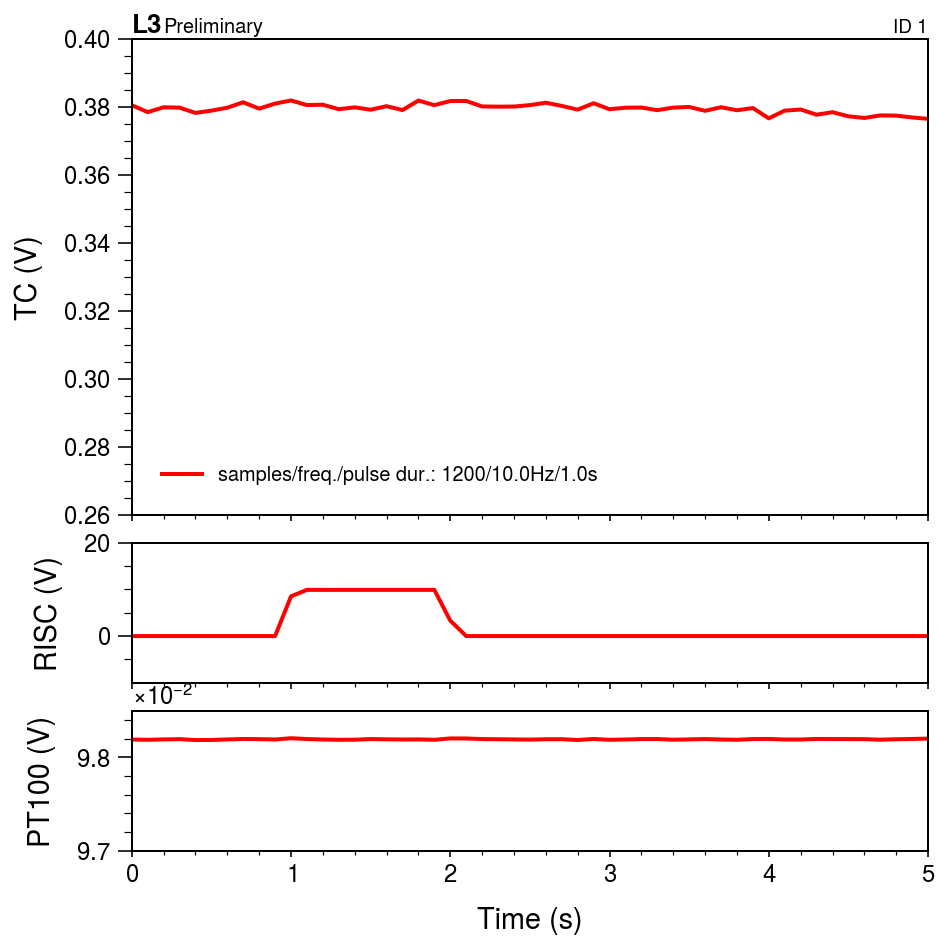

In [8]:
D1.prelim_plot(0,5, True)

In questo modo la variazione della temperatura sulla termocoppia è sensata e sicuramente maggiore dell'offset. Possiamo allora provare ad ottenere la linearizzazione di cui i grafici sono riportati sopra. 

Osservando il $p$-value del $\chi^2$ minimizzato comunque vediamo che un modello lineare non approssima bene i dati, che invece son più simili ad un modello di secondo ordine. 

### Fit con il modello completo

Possiamo considerare come seconda opzione di trovare il valore di $D$ come approssimazione per il modello della sbarretta semi infinita sui dati (raccolti su una sbarretta finita), che però sono validi solo per tempi relativamente piccoli. Mettendoci nell'intervallo per cui $10\lesssim t\lesssim28$s, allora possiamo ottenere (si noti che anche in questo caso i dati sono riportati con l'origine delle curve nello zero anche se non sarebbe davvero necessario) i valori di D che rispettano la relazione (1). 

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.38(8)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D1)    
│ (p-value: 0.2767813362014787, χ2/df = (177.37079810061437, 167.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 1.018(8)e-05 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D2)    
│ (p-value: 0.10010426705296338, χ2/df = (180.08270596338429, 157.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.70(11)e-06 m^2/s 	for samples/freq./pulse dur.: 240/2.0Hz/1.0s (D3)    
│ (p-value: 0.01701896911656875, χ2/df = (47.38212778982111, 29.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.76(15)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/0.5s (D4)    
│ (p-value: 0.9722753364820487, χ2/df = (133.81214947771915, 167.0))

┌─────────────────────────────────────────────────────────────────────────    


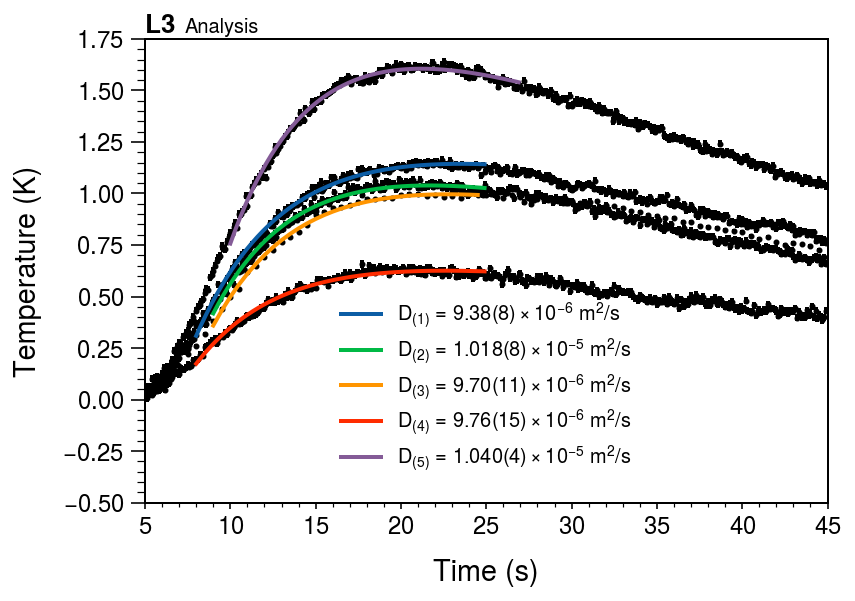

In [9]:
fit_limits = [
    (8,25), #> D1
    (9,25), #> D2
    (9,25), #> D3
    (8,25), #> D4
    (10,27), #> D5
]

for i, D in enumerate(datasets):
    value, error, M = Analysis(D).filter(5, 45).full_model_fit(fit_limits=fit_limits[i])

plt.ylim(-0.5, 1.75)
hep.label.exp_text('L3 ', 'Analysis')
plt.legend()
plt.savefig('fplot_1-5.pdf', bbox_inches='tight')

### Osservazioni

Vediamo che con questo modello, come potevamo anche aspettarci, il $p$-value è abbastanza buono, e i risultati sono, almeno nell'ordine di grandezza, simili tra loro e anche con i risultati ottenuti nel modello lineare. 